In [86]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import collections

import statsmodels.api as sm

from functions import *
import warnings

Reference: https://medium.com/@blazetamareborn/practicing-clustering-techniques-on-survey-dataset-f7d7a322e6ff

In [87]:
X = pd.read_csv("indep_x.csv", index_col = 0)
y = pd.read_csv("dep_y.csv", index_col = 0)

In [88]:
df = pd.concat([X,y], axis = 1)

In [89]:
X.loc[X["gpa"] == 31, "gpa"] = 17
df.loc[df["gpa"] == 31, "gpa"] = 17

#X = X[X["gpa"]!=31]
#df = df[df["gpa"]!=31]

In [90]:
df_means = df.mean(axis = 0)

In [91]:
df_means

age               19.816993
gender             0.470588
scholarship        0.071895
1st_year           0.934641
gpa               24.366013
1st_time           0.980392
taste              3.339869
importance         3.934641
expected_grade    21.901961
knowledge          0.300654
treated            0.496732
grade_goal        25.013072
confidence         3.450980
anxiety            3.339869
time               4.607843
exam_date          1.143791
dtype: float64

In [92]:
df_std = df.std()

In [93]:
df_std/df_means

age               0.060276
gender            1.064143
scholarship       3.604722
1st_year          0.265311
gpa               0.125683
1st_time          0.141886
taste             0.191728
importance        0.169173
expected_grade    0.117667
knowledge         1.530160
treated           1.009863
grade_goal        0.133149
confidence        0.261602
anxiety           0.285629
time              0.236474
exam_date         0.353409
dtype: float64

In [94]:
scaler = StandardScaler()
s_data_df = scaler.fit_transform(df)
s_data_X = scaler.fit_transform(X)

### Removal of Outliers using DBSCAN

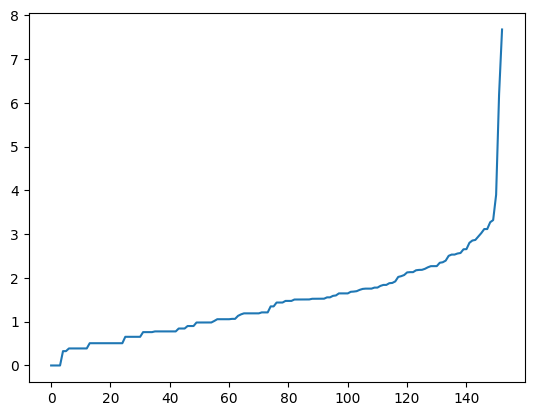

In [95]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(s_data_X)
distances, indices = neighbors_fit.kneighbors(s_data_X)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.show()

In [96]:
dbscan = DBSCAN(eps=3.5, min_samples=20)

In [97]:
labels = dbscan.fit_predict(s_data_X)

In [98]:
outlier_mask = labels == -1

In [99]:
x_data_nout = s_data_X[~outlier_mask]
all_data_nout = s_data_df[~outlier_mask]

In [100]:
x_nout = X[~outlier_mask]
df_nout = df[~outlier_mask]

In [101]:
(df_nout.shape[0], x_nout.shape[0])

(129, 129)

In [102]:
df_nout.shape[0]/df.shape[0]

0.8431372549019608

### Preliminary PCA Check

In [103]:
x_treated = x_nout["treated"].copy()
x_nout = x_nout.drop(["treated"], axis = 1)


In [104]:
pca = PCA(n_components = 3, random_state=1)
x_pca = pca.fit_transform(x_nout)

In [105]:
pca.explained_variance_ratio_

array([0.52103754, 0.35553272, 0.05918915])

In [106]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [107]:
cumulative_variance

array([0.52103754, 0.87657026, 0.9357594 ])

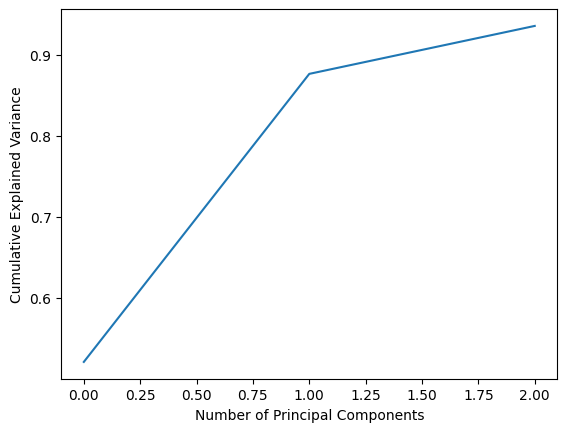

In [108]:
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [109]:
distortions = []
K_to_try = range(1, 8)

In [110]:
for i in K_to_try:
    model = KMeans(
            n_clusters=i,
            init='k-means++',
            random_state=1)
    model.fit(x_pca)
    distortions.append(model.inertia_)

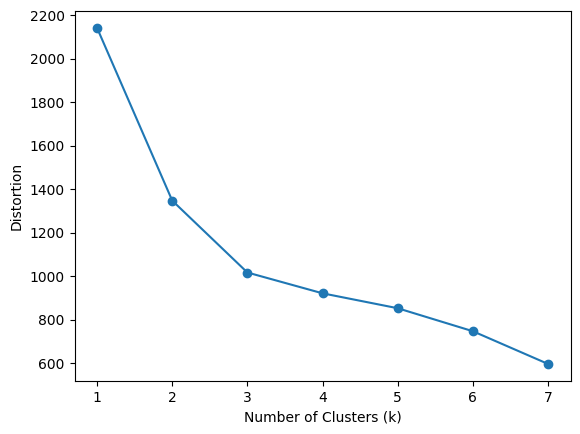

In [111]:
plt.plot(K_to_try, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

In [112]:
model = KMeans(
    n_clusters=3,
    init='k-means++',
    random_state=1)

In [113]:
model = model.fit(x_pca)

y = model.predict(x_pca)

In [114]:
x_pca_rendered = pd.DataFrame(x_pca)

In [115]:
x_pca_rendered["cluster"] = y

centroids = model.cluster_centers_

In [116]:
silhouette_avg = silhouette_score(x_pca_rendered[[0,1]], x_pca_rendered["cluster"])

In [117]:
silhouette_avg

np.float64(0.3417082199872262)

In [118]:
cluster_counts = collections.Counter(y)
print(cluster_counts)

Counter({np.int32(0): 58, np.int32(2): 40, np.int32(1): 31})


### Actual Clustering

In [141]:
model_k = KMeans(
    n_clusters=5,
    init='k-means++',
    random_state=1)

In [143]:
model_k = model_k.fit(s_data_X)

y_final = model_k.predict(s_data_X)

In [144]:
cluster_counts = collections.Counter(y_final)
print(cluster_counts)

Counter({np.int32(3): 52, np.int32(4): 45, np.int32(0): 35, np.int32(1): 11, np.int32(2): 10})


In [145]:
x_nout_k = x_nout.copy() #If x_nout is a view, this will make it a copy.
df_nout_k = df_nout.copy() #If df_nout is a view, this will make it a copy.

x_nout_k.loc[:, "cluster"] = y_final
df_nout_k.loc[:, "cluster"] = y_final

ValueError: Length of values (153) does not match length of index (129)

In [130]:
silhouette_avg = silhouette_score(x_nout_k.drop(["cluster"], axis = 1), x_nout_k["cluster"])

In [131]:
silhouette_avg

np.float64(0.25145004334154797)

In [61]:
df_nout.columns

Index(['age', 'gender', 'scholarship', '1st_year', 'gpa', '1st_time', 'taste',
       'importance', 'expected_grade', 'knowledge', 'treated', 'grade_goal',
       'confidence', 'anxiety', 'time', 'exam_date', 'cluster'],
      dtype='object')

In [62]:
y_vars = df_nout[['grade_goal','confidence', 'anxiety', 'time', 'exam_date', 'cluster']]

In [63]:
x_nout.head()

,age,gender,scholarship,1st_year,gpa,1st_time,taste,importance,expected_grade,knowledge,cluster
2,19,1,0,1,25,1,3,4,21,0,0
4,19,1,0,1,25,1,3,3,19,1,0
5,23,1,0,1,20,1,3,3,22,0,1
7,19,1,0,1,25,1,4,3,21,1,0
8,21,0,0,1,23,1,3,4,19,0,1


In [64]:
y_vars.head()

,grade_goal,confidence,anxiety,time,exam_date,cluster
2,25,3,5,4,1,0
4,20,3,4,6,1,0
5,25,3,3,5,2,1
7,25,4,5,4,1,0
8,23,4,2,6,1,1


In [65]:
ate_results = {}

for cluster_id in x_nout['cluster'].unique():
    ate_results[cluster_id] = {}
    for var in y_vars.columns[:-1]:
        cluster_data = x_nout[x_nout['cluster'] == cluster_id].drop(["cluster"], axis = 1)
        X = sm.add_constant(cluster_data) 
        y = y_vars[y_vars['cluster'] == cluster_id]
        y = y[var] 
        model = sm.OLS(y, X).fit(cov_type='HC3')
        ate_results[cluster_id][var] = model.params['treated']

KeyError: 'treated'

In [222]:
pd.options.display.float_format = '{:.2f}'.format

pd.DataFrame(ate_results)

,0,1,3,4,2
grade_goal,-1.65,1.63,-1.62,3.53,-2.43
confidence,-0.64,0.52,-0.03,-0.88,-0.07
anxiety,0.37,-0.41,-0.40,-1.26,0.52
time,0.39,1.04,0.04,-2.52,0.55
exam_date,-0.03,-0.06,0.10,-0.38,-0.05


### Spectral Clustering

In [140]:
n_clusters = 5
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)

In [ ]:
labels = spectral_clustering.fit_predict(s)

In [138]:
cluster_counts = collections.Counter(labels)
print(cluster_counts)

Counter({np.int32(1): 59, np.int32(4): 37, np.int32(2): 28, np.int32(0): 18, np.int32(3): 11})


In [139]:
x_nout_s = x_nout.copy() #If x_nout is a view, this will make it a copy.
df_nout_s = df_nout.copy() #If df_nout is a view, this will make it a copy.

x_nout_s.loc[:, "cluster"] = labels
df_nout_s.loc[:, "cluster"] = labels

ValueError: Length of values (153) does not match length of index (129)